##Libraries


In [2]:
!pip install --upgrade tensorflow
!sudo apt-get install libcairo2-dev pkg-config poppler-utils tesseract-ocr libtesseract-dev
!pip install pycairo reportlab>=3.6.2 PyPDF2==1.26.0 python-doctr[tf] pillow PyMuPDF pandas pdf2image fuzzywuzzy python-Levenshtein pytesseract natsort tf2onnx scikit-learn opencv-python-headless

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
libtesseract-dev is already the newest version (4.1.1-2.1build1).
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


##Libraries

In [1]:
# Core Libraries
import os
import re
from tempfile import TemporaryDirectory

# External Libraries
import PyPDF2
from PyPDF2 import PdfFileMerger
import cv2
import fitz  # PyMuPDF
import pandas as pd
from PIL import Image, ImageDraw, ImageEnhance, ImageFilter, ImageOps
from reportlab.lib.colors import black
from reportlab.lib.units import inch
from reportlab.pdfgen.canvas import Canvas
import pytesseract

# Doctr-related imports
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

# PDF-related imports
from pdf2image import convert_from_path

# Miscellaneous
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


##Clasificador

In [2]:
def get_pdf_size(path, tolerance=0.10):
    # Open the PDF file
    pdf = fitz.open(path)

    # Create a dictionary to store the count of each page size
    page_size_counts = {}

    # Iterate through each page in the PDF
    for page_number in range(pdf.page_count):
        page = pdf[page_number]
        width, height = page.rect.width, page.rect.height

        # Define the sizes in points with a tolerance
        sizes = {
            'A0': (2384, 3370),
            'A1': (1684, 2384),
            'A2': (1191, 1684),
            'A3': (842, 1191),
            'A4': (595, 842),
        }

        # Compare the dimensions to determine the size within the tolerance
        for size, dims in sizes.items():
            if (
                (abs(width - dims[0]) <= dims[0] * tolerance and abs(height - dims[1]) <= dims[1] * tolerance)
                or (abs(width - dims[1]) <= dims[1] * tolerance and abs(height - dims[0]) <= dims[0] * tolerance)
            ):
                # Increment the count for the current page size
                page_size_counts[size] = page_size_counts.get(size, 0) + 1

    # Find the most repeated page size
    most_repeated_size = max(page_size_counts, key=page_size_counts.get)

    return most_repeated_size, page_size_counts, pdf.page_count, pdf  # Include the PDF object in the return

def classify_document(pdf_path):
    # Check if it's a drawing
    most_repeated_size, page_size_counts, num_pages, pdf = get_pdf_size(pdf_path)

    if most_repeated_size == 'A4':
        return f"This is a PDF-Document, Most Repeated Size: {most_repeated_size}, Page Size Counts: {page_size_counts}, Number of Pages: {num_pages}."
    else:
        # Run the subprogram if it's a drawing
        from cutborders_py import process_pdf
        process_pdf(pdf_path)

        def extract_comments_with_bboxes(pdf_path, zoom=2):
            doc = fitz.open(pdf_path)
            comments_with_bboxes = []

            for page_num in range(len(doc)):
                page = doc.load_page(page_num)

                for annot in page.annots():
                    # Get bounding box of the annotation
                    bbox = annot.rect
                    x0, y0, x1, y1 = bbox.x0, bbox.y0, bbox.x1, bbox.y1

                    # Apply the zoom scaling to the bounding box coordinates
                    scaled_bbox = [coord * zoom for coord in [x0, y0, x1, y1]]

                    annot_info = {
                        "page": page_num,
                        "type": annot.type[1],
                        "content": annot.info["content"],
                        "bbox_x1": scaled_bbox[0],
                        "bbox_y1": scaled_bbox[1],
                        "bbox_x2": scaled_bbox[2],
                        "bbox_y2": scaled_bbox[3]
                    }
                    comments_with_bboxes.append(annot_info)

            doc.close()

            # Convert list of comments with bounding boxes to a DataFrame
            comments_df = pd.DataFrame(comments_with_bboxes)

            return comments_df

        # Extract comments and their bounding boxes from the PDF, scaling them to match the image
        comments_with_bboxes_df = extract_comments_with_bboxes(pdf_path, zoom=2)

        # Display the DataFrame
        display(comments_with_bboxes_df)

        # Save the DataFrame to a CSV file
        csv_path = "/content/comments_with_bboxes.csv"  # Replace with your desired path

        #comments_with_bboxes_df.to_csv(csv_path, index=False) #DEACTIVATE CODE
        comments_with_bboxes_df= [] #DEACTIVATE CODE, LA RAZON ES QUE A VECES LA CAPA DE TEXTO DEL PDF NO CONTIENE TODOS LOS CAMPOS DE TEXTO CON LO CUAL INDICE A UN ERROR.
        print(f"Comments with bounding boxes saved to {csv_path}")


        try:
            df_OCR_HORIZONTAL = comments_with_bboxes_df
            if len(df_OCR_HORIZONTAL) == 0:
                print("DataFrame is empty after loading")
                print("No se pudo extraer capa de texto, UTILIZAR OCR")
                result = !python passtheocr.py

                # Read the original CSV file
                original_df = pd.read_csv('/content/final_output.csv')

                # Create a new DataFrame with 'tile_num' and 'text' columns
                new_df = pd.DataFrame(columns=['tile_num', 'text'])

                # Iterate over unique tile numbers and concatenate all texts consecutively
                for tile_num in original_df['tile_num'].unique():
                    # Filter rows for the current tile number
                    rows_for_tile = original_df[original_df['tile_num'] == tile_num]

                    # Concatenate all texts consecutively
                    concatenated_text = ' '.join(rows_for_tile['text'].astype(str))

                    # Append a new row to the new DataFrame
                    new_df = pd.concat([new_df, pd.DataFrame({'tile_num': [tile_num], 'text': [concatenated_text]})], ignore_index=True)

                # Save the new DataFrame to a new CSV file
                new_df.to_csv('modified_csv_path.csv', index=False)
                df = pd.read_csv('/content/modified_csv_path.csv')
            else:
                df_OCR_HORIZONTAL = df_OCR_HORIZONTAL[df_OCR_HORIZONTAL['content'].notna()]
                df_OCR_HORIZONTAL = df_OCR_HORIZONTAL.rename(columns={'content': 'text'})
                df=df_OCR_HORIZONTAL
                #print(df_OCR_HORIZONTAL)

        except pd.errors.EmptyDataError:
            print("Caught EmptyDataError")
            print("No se pudo extraer layout de texto, UTILIZAR OCR")


        keywords = [
            'electrical', 'electric', 'wiring', 'wiring diagram',
            'eléctrico', 'eléctrica', 'cableado',
            'circuito', 'circuit', 'unifilar'
        ]

        is_electrical_diagram = any(df['text'].str.contains('|'.join(keywords), case=False, na=False))

        # Additional classification for PDF-P&ID
        pid_keywords = ['P&ID', 'PID']  # Add more P&ID-related keywords here
        is_pid_document = any(df['text'].str.contains('|'.join(pid_keywords), case=False, na=False))

        # Additional classification for PDF-Drawing Isometric
        drawing_keywords = ['VISTA ISOMÉTRICA', 'VISTA ISOMÉTRICO', 'ISOMÉTRICO', 'ISOMÉTRICA']  # Add more drawing-related keywords here
        is_drawing_Isometric = any(df['text'].str.contains('|'.join(drawing_keywords), case=False, na=False))

        # Additional classification for PDF-Drawing PEDESTAL Arrangement
        arragment_keywords = ['PEDESTAL']  # Add more drawing-related keywords here
        is_drawing_Pedestal = any(df['text'].str.contains('|'.join(arragment_keywords), case=False, na=False))

        # Additional classification for PDF-Drawing General Arrangement
        arragment_keywords = ['VISTA FRONTAL', 'VISTA PLANTA', 'VISTA LATERAL', 'ARREGLO GENERAL']  # Add more drawing-related keywords here
        is_drawing_General = any(df['text'].str.contains('|'.join(arragment_keywords), case=False, na=False))

        if is_pid_document:
            document_type = 'PDF-P&ID'
        elif is_electrical_diagram:
            document_type = 'PDF-Electrical Diagram'
        elif is_drawing_Isometric:
            document_type = 'PDF-Drawing Isometric'
        elif is_drawing_Pedestal:
            document_type = 'PDF-Drawing Pedestal'
        elif is_drawing_General:
            document_type = 'PDF-Drawing General Arragment'
        else:
            document_type = 'PDF-Drawing Others'

        # Extract the PDF name from the pdf_path
        pdf_name = os.path.basename(pdf_path)

        # Close the PDF file after extracting information
        pdf.close()

        return f"This is a {document_type}-{pdf_name}, Most Repeated Size: {most_repeated_size}, Page Size Counts: {page_size_counts}, Number of Pages: {num_pages}."

# Example usage:
pdf_path = '/content/LP012085A-0370-0420-PID-00004_Rev2 (1) (1).pdf'
result_message = classify_document(pdf_path)
print(result_message)

""


Comments with bounding boxes saved to /content/comments_with_bboxes.csv
DataFrame is empty after loading
No se pudo extraer capa de texto, UTILIZAR OCR
This is a PDF-P&ID-LP012085A-0370-0420-PID-00004_Rev2 (1) (1).pdf, Most Repeated Size: A3, Page Size Counts: {'A3': 1, 'A4': 1}, Number of Pages: 2.


##Detector de tamanos de texto

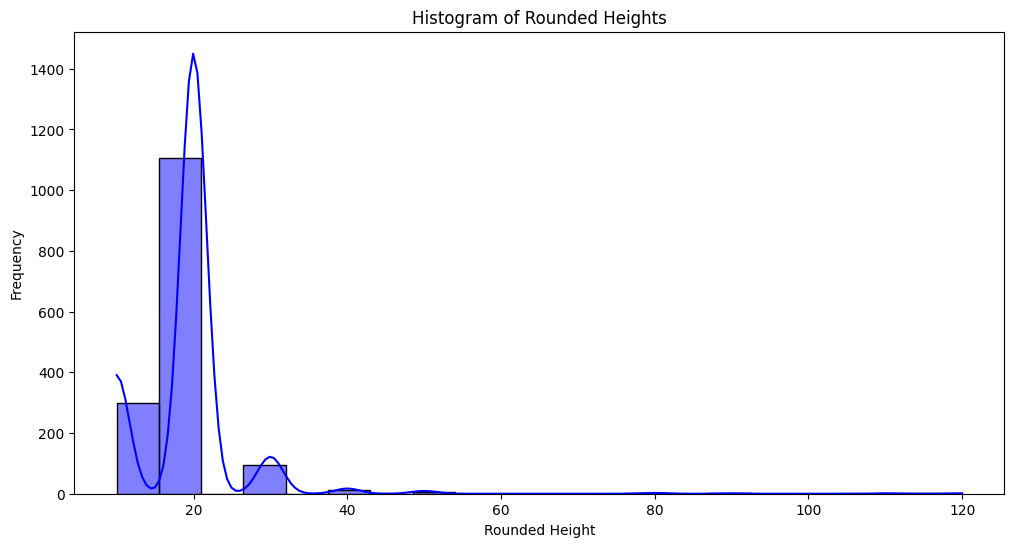

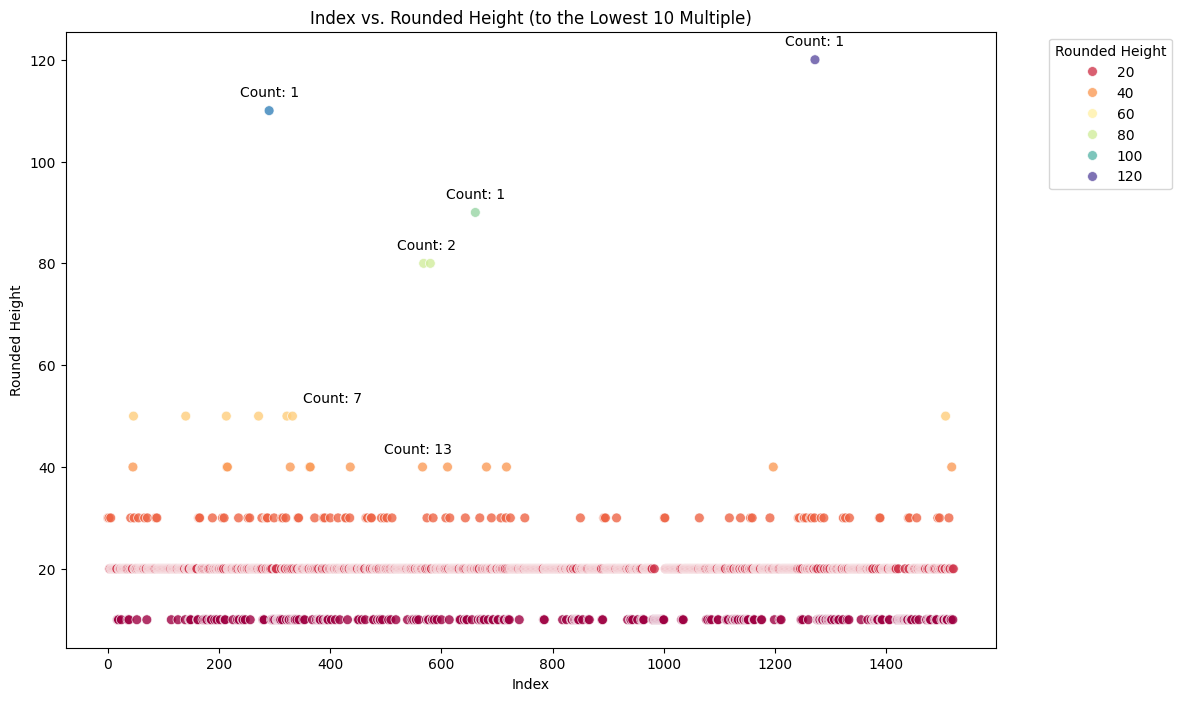

In [21]:
def process_csv_and_plot_graph(csv_path, output_csv_path):
    # Load the CSV file
    data = pd.read_csv(csv_path)

    # Calculate the height of each bbox
    data['height'] = data['y2'] - data['y1']

    # Calculate the rounded height to the lowest 10 multiple
    data['rounded_height'] = 10 * (data['height'] // 5)

    # Count the number of occurrences for each unique rounded height
    rounded_height_counts = data['rounded_height'].value_counts().reset_index()
    rounded_height_counts.columns = ['Rounded Height', 'Count']

    # Determine the threshold based on the first third of the percentile
    percentile_threshold = rounded_height_counts['Count'].quantile(0.7)

    # Filter rounded_heights based on the percentile threshold
    filtered_rounded_heights = rounded_height_counts[rounded_height_counts['Count'] < percentile_threshold]['Rounded Height']

    # Create a DataFrame for oversized_text rows based on filtered rounded_heights
    oversized_text_data = data[data['rounded_height'].isin(filtered_rounded_heights)]

    # Exclude rows where 'text' column contains only characters like "-", "(", ")", ":"
    #oversized_text_data = oversized_text_data[~oversized_text_data['text'].str.match(r'^[-():]+$')]

    # Adjusting the groupby call to avoid the FutureWarning and fix the AttributeError
    oversized_text_data = oversized_text_data.groupby(['text', 'rounded_height'], as_index=False, group_keys=False).apply(
        lambda group: group.sort_values('tile_num').drop_duplicates('text', keep='last')
    )

    # Save the oversized_text data to a new CSV file
    oversized_text_data.to_csv(output_csv_path, index=False)

    # Plot the histogram of rounded heights and save it
    plt.figure(figsize=(12, 6))
    sns.histplot(data=data, x='rounded_height', bins=20, kde=True, color='blue')
    plt.title('Histogram of Rounded Heights')
    plt.xlabel('Rounded Height')
    plt.ylabel('Frequency')
    plt.savefig('/content/histogram_of_rounded_heights.png')

    # Plot the index vs. rounded heights with different colors and display the quantity
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=data, x=data.index, y="rounded_height", hue="rounded_height", palette="Spectral", s=50, alpha=0.8)
    plt.title('Index vs. Rounded Height (to the Lowest 10 Multiple)')
    plt.xlabel('Index')
    plt.ylabel('Rounded Height')
    plt.legend(title='Rounded Height', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Corrected annotation of the points with the quantity of indexes in each category
    for index, row in rounded_height_counts.iterrows():
        if row["Rounded Height"] in filtered_rounded_heights.values:
            mean_index = data[data['rounded_height'] == row["Rounded Height"]].index.to_series().mean()
            plt.annotate(f'Count: {row["Count"]}', (mean_index, row["Rounded Height"]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.savefig('/content/index_vs_rounded_height.png')
    plt.show()

# Specify the path to your CSV file and the path for saving the updated CSV
csv_file_path = '/content/final_output.csv'
output_csv_path = '/content/oversized_text.csv'

# Call the function to process the CSV, create the graph, and save the updated data
process_csv_and_plot_graph(csv_file_path, output_csv_path)



In [27]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle
import numpy as np

def draw_revision_cloud(ax, points, arc_radius=2, arc_angle=45):
    """
    Draw a revision cloud with arcs around the given points and a semi-transparent fill.
    """
    x_min, x_max = min(point[0] for point in points), max(point[0] for point in points)
    y_min, y_max = min(point[1] for point in points), max(point[1] for point in points)

    rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, color='blue', alpha=0.2)
    ax.add_patch(rect)

    for i in range(len(points)):
        start_point = points[i]
        end_point = points[(i + 1) % len(points)]
        line_angle = np.arctan2(end_point[1] - start_point[1], end_point[0] - start_point[0])
        distance = np.hypot(end_point[1] - start_point[1], end_point[0] - start_point[0])
        num_arcs = int(distance // (2 * arc_radius)) + 1

        for j in range(num_arcs):
            center_x = start_point[0] + (2 * arc_radius * j + arc_radius) * np.cos(line_angle)
            center_y = start_point[1] + (2 * arc_radius * j + arc_radius) * np.sin(line_angle)
            angle_offset = np.deg2rad(arc_angle / 2) if j % 2 == 0 else -np.deg2rad(arc_angle / 2)
            arc = Arc((center_x, center_y), 2 * arc_radius, 2 * arc_radius,
                      angle=np.rad2deg(line_angle) - 90,
                      theta1=np.rad2deg(angle_offset),
                      theta2=np.rad2deg(angle_offset) + 180,
                      color='blue', linewidth=2)
            ax.add_patch(arc)

csv_data = pd.read_csv('/content/oversized_text.csv')
tiles_directory = '/content/tiles'
output_directory = '/content/modified_tiles'
os.makedirs(output_directory, exist_ok=True)

for tile_num, group in csv_data.groupby('tile_num'):
    tile_path = os.path.join(tiles_directory, f'tile_{tile_num}.png')

    if os.path.exists(tile_path):
        tile_image = Image.open(tile_path)
        dpi = 100  # Adjust DPI to your needs
        img_width, img_height = tile_image.size
        figsize = img_width / dpi, img_height / dpi  # Convert pixels to inches for figsize

        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        ax.imshow(tile_image)
        ax.axis('off')

        for index, row in group.iterrows():
            points = [(row['x1'], row['y1']), (row['x1'], row['y2']),
                      (row['x2'], row['y2']), (row['x2'], row['y1']),
                      (row['x1'], row['y1'])]
            draw_revision_cloud(ax, points)

        modified_tile_path = os.path.join(output_directory, f'modified_tile_{tile_num}.png')
        plt.savefig(modified_tile_path, bbox_inches='tight', pad_inches=0, dpi=dpi)
        plt.close()


In [28]:
from PIL import Image, ImageDraw
import os

def assemble_modified_tiles_with_text(output_directory, final_output_path):
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    modified_tiles = [os.path.join(output_directory, f) for f in os.listdir(output_directory) if f.endswith('.png')]
    modified_tiles.sort()  # Sort files if needed

    # Parameters to control the appearance of the separator and text
    separator_height = 20  # Space for the separator
    line_thickness = 10    # Thickness of the line
    text_height = 40       # Additional space for the text to simulate a larger font

    # Calculate total height and maximum width
    total_height = 0
    max_width = 0
    for tile_path in modified_tiles:
        tile = Image.open(tile_path)
        total_height += tile.height + separator_height + text_height + line_thickness  # Adjust total height
        max_width = max(max_width, tile.width)

    # Create a new image with the calculated total height and maximum width
    assembled_image = Image.new('RGB', (max_width, total_height), 'white')
    draw = ImageDraw.Draw(assembled_image)

    current_height = 0
    for tile_path in modified_tiles:
        # Draw text "Corrección" at the top of each tile
        text_offset_y = current_height  # Text offset at the current height
        draw.text((50, text_offset_y), "TEXTO ENCONTRADO CON TAMANO DE LETRA DIFERENTE: ", fill='red')

        # Update current height after adding the text
        current_height += text_height

        # Paste the tile
        tile = Image.open(tile_path)
        assembled_image.paste(tile, (0, current_height))
        current_height += tile.height

        # Draw a separator line if there's space for more tiles
        if current_height < total_height - separator_height - line_thickness:
            draw.line([(0, current_height), (max_width, current_height)], fill='black', width=line_thickness)
            current_height += line_thickness + separator_height

    # Save the final assembled image
    assembled_image.save(final_output_path)

# Specify the output directory containing modified tiles and the path for the final assembled image
output_directory = '/content/modified_tiles'
final_output_path = '/content/assembled_tiles_with_text.png'
assemble_modified_tiles_with_text(output_directory, final_output_path)

